### Rebalancing the portfolio
#### 10.05.2019

In [2]:
# connection necessary packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

## Helpfull functions

In [3]:
# profitability of the portfolio
def port_mean(d, means, n_days=250):
    d = np.array(d)
    return np.sum(means * d) * n_days


# volatility of the portfolio
def port_vol(d, cov, n_days=250):
    d = np.array(d)
    return np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))


# best portfolio
def port_best(d, cov, means, n_days=250):
    d = np.array(d)
    mean = np.sum(means * d) * n_days
    vol = np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))
    return -(mean / vol)

    
# Vallue at Risk (VaR) of asset
def asset_VaR(df, alpha = 5):
    var = []
    col = list(df.columns)
    for i in col:
        num = sorted(list(df[i]))
        var.append(-np.percentile(num, 5))
    return var


# Portfolio Value at Risk 
def port_VaR(weights, var):
    a = np.array(weights)
    b = np.array(var)
    return np.dot(a, b)


# Flag
def flag(df, n_assets):
    df['Flag'] = 0
    for i in range(1, len(df.index)):
        b = i - 1
        if df.index.year[i] != df.index.year[b] or i == (len(df.index) - 1):
            df.iloc[i, n_assets] = 1
            

# Start - Stop
def sr_st(df):
    start =[str(post_per.index[0])[:10]]
    for i in un.index[:-1]:
        b = str(i)[:10]
        start.append(b)
    stop = []
    for i in un.index:
        b = str(i)[:10]
        stop.append(b)
    return start, stop

        
# filter dataframe
def filter_df(df, start, stop):
        df = df[df.index >= start]
        df = df[df.index <= stop]
        return df


In [36]:
# data parse
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
# download and calculate data
index = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/MOEXBC_c.csv'
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, date_parser=dateparse, sep=';')
bond = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/RGBITR_c.csv'
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, date_parser=dateparse, sep=';')
col = index.columns.values
for c in col:
    if c == 'CLOSE':
        continue
    del index[c]
    del bond[c]
port_weight = [.5, .5]
n_assets = 2

In [37]:
main = pd.merge(index, bond, left_index = True, right_index = True)
main.columns = ['Index', 'Bond']
flag(main, n_assets)
main.head()

,Index,Bond,Flag
Index_Date,,,
2012-04-02,10385.31,284.03,0
2012-04-03,10581.19,284.09,0
2012-04-04,10337.60,283.81,0
2012-04-05,10427.70,283.85,0
2012-04-06,10240.05,283.69,0


In [38]:
# portfolio value
v = 100000
p_v = [i * v for i in port_weight]
# assets share
bc_share = round(p_v[0] / main['Index'][0], 4)
bn_share = round(p_v[1] / main['Bond'][0], 4)
print(*[bc_share, bn_share])
print(round(bc_share * main['Index'][0], 2), round(bn_share * main['Bond'][0], 2), 
     round(bc_share * main['Index'][0], 2) + round(bn_share * main['Bond'][0], 2))

4.8145 176.0377
50000.07 49999.99 100000.06


In [39]:
blu = round(v / main['Index'][0])
bnd = round(v / main['Bond'][0])

In [40]:
work_block = pd.DataFrame({
    'Blue Chips': main['Index'], 'Bond Index': main['Bond'],
    'Index Share': bc_share, 'Bond Share': bn_share,
    'Index': main['Index'] * blu, 'Bond': main['Bond'] * bnd,
    '50/50': main['Index'] * bc_share + main['Bond'] * bn_share,
                           })
work_block['Port'] = work_block['50/50']
work_block['Flag'] = main['Flag']
work_block['ss'] = work_block['Blue Chips'] * work_block['Index Share'] / work_block['50/50']
work_block.head()

,Blue Chips,Bond Index,Index Share,Bond Share,Index,Bond,50/50,Port,Flag,ss
Index_Date,,,,,,,,,,
2012-04-02,10385.31,284.03,4.8145,176.0377,103853.1,99978.56,100000.062926,100000.062926,0,0.500000
2012-04-03,10581.19,284.09,4.8145,176.0377,105811.9,99999.68,100953.689448,100953.689448,0,0.504619
2012-04-04,10337.60,283.81,4.8145,176.0377,103376.0,99901.12,99731.634837,99731.634837,0,0.499043
2012-04-05,10427.70,283.85,4.8145,176.0377,104277.0,99915.20,100172.462795,100172.462795,0,0.501177
2012-04-06,10240.05,283.69,4.8145,176.0377,102400.5,99858.88,99240.855838,99240.855838,0,0.496778


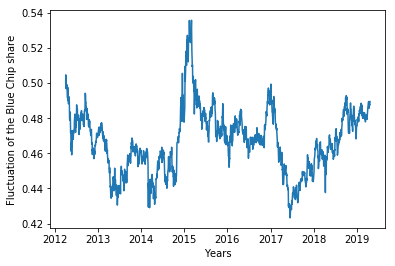

In [41]:
_=plt.plot(work_block.index, work_block['ss'])
_=plt.xlabel('Years')
_=plt.ylabel('Fluctuation of the Blue Chip share')

In [17]:
# portfolio rebalancing
num = len(work_block)
for i in range(1, num):
    b = i - 1
    if work_block.iloc[i, 8] == 1:
        work_block.iloc[i, 2] = work_block.iloc[i, 7] / (2 * work_block.iloc[i, 0])
        work_block.iloc[i, 3] = work_block.iloc[i, 7] / (2 * work_block.iloc[i, 1])
        work_block.iloc[i, 7] = work_block.iloc[i, 0] * work_block.iloc[i, 2] + work_block.iloc[i, 1] * work_block.iloc[i, 3]
    else:
        work_block.iloc[i, 2] = work_block.iloc[b, 2]
        work_block.iloc[i, 3] = work_block.iloc[b, 3]
        work_block.iloc[i, 7] = work_block.iloc[i, 0] * work_block.iloc[i, 2] + work_block.iloc[i, 1] * work_block.iloc[i, 3]

In [18]:
temp = work_block.copy()
del temp['Blue Chips']
del temp['Bond Index']
del temp['Index Share']
del temp['Bond Share']
del temp['Flag']
temp.head()

,Index,Bond,50/50,Port,ss
Index_Date,,,,,
2012-04-02,103853.1,99978.56,100000.120845,100000.120845,0.800000
2012-04-03,105811.9,99999.68,101513.248567,101513.248567,0.802940
2012-04-04,103376.0,99901.12,99617.109851,99617.109851,0.799387
2012-04-05,104277.0,99915.20,100313.984775,100313.984775,0.800752
2012-04-06,102400.5,99858.88,98857.212879,98857.212879,0.797930


Text(0.5, 0, 'Years')

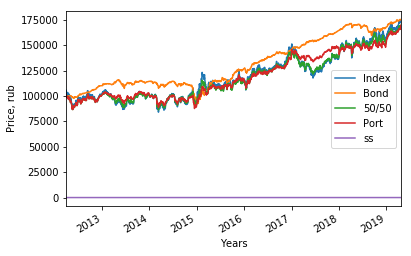

In [19]:
ax = temp.plot()
ax.set_ylabel("Price, rub")
ax.set_xlabel("Years")

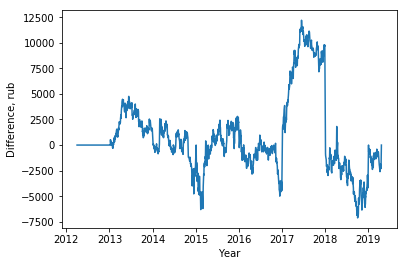

In [20]:
_=plt.plot(work_block.index, (work_block['Port'] - work_block['50/50']))
_=plt.xlabel('Year')
_=plt.ylabel('Difference, rub')

### Rebalancing once a month

In [21]:
# Flag month
def flag_m(df, n_assets):
    df['Flag'] = 0
    for i in range(1, len(df.index)):
        b = i - 1
        if df.index.month[i] != df.index.month[b] or i == (len(df.index) - 1):
            df.iloc[i, n_assets] = 1

In [22]:
main_month = main.copy()
flag_m(main_month, n_assets)

In [23]:
# portfolio value
v = 100000
p_v = [i * v for i in port_weight]
# assets share
bc_share = round(p_v[0] / main_month['Index'][0], 4)
bn_share = round(p_v[1] / main_month['Bond'][0], 4)
print(*[bc_share, bn_share])
print(round(bc_share * main_month['Index'][0], 2), round(bn_share * main_month['Bond'][0], 2), 
     round(bc_share * main_month['Index'][0], 2) + round(bn_share * main_month['Bond'][0], 2))
blu = round(v / main_month['Index'][0])
bnd = round(v / main_month['Bond'][0])
work_block = pd.DataFrame({
    'Blue Chips': main_month['Index'], 'Bond Index': main_month['Bond'],
    'Index Share': bc_share, 'Bond Share': bn_share,
    'Index': main_month['Index'] * blu, 'Bond': main_month['Bond'] * bnd,
    '50/50': main_month['Index'] * bc_share + main_month['Bond'] * bn_share
                           })
work_block['Port'] = work_block['50/50']
work_block['Flag'] = main_month['Flag']
work_block.head()

7.7032 70.4151
80000.12 20000.0 100000.12


,Blue Chips,Bond Index,Index Share,Bond Share,Index,Bond,50/50,Port,Flag
Index_Date,,,,,,,,,
2012-04-02,10385.31,284.03,7.7032,70.4151,103853.1,99978.56,100000.120845,100000.120845,0
2012-04-03,10581.19,284.09,7.7032,70.4151,105811.9,99999.68,101513.248567,101513.248567,0
2012-04-04,10337.60,283.81,7.7032,70.4151,103376.0,99901.12,99617.109851,99617.109851,0
2012-04-05,10427.70,283.85,7.7032,70.4151,104277.0,99915.20,100313.984775,100313.984775,0
2012-04-06,10240.05,283.69,7.7032,70.4151,102400.5,99858.88,98857.212879,98857.212879,0


In [24]:
# portfolio rebalancing
num = len(work_block)
for i in range(1, num):
    b = i - 1
    if work_block.iloc[i, 8] == 1:
        work_block.iloc[i, 2] = work_block.iloc[i, 7] / (2 * work_block.iloc[i, 0])
        work_block.iloc[i, 3] = work_block.iloc[i, 7] / (2 * work_block.iloc[i, 1])
        work_block.iloc[i, 7] = work_block.iloc[i, 0] * work_block.iloc[i, 2] + work_block.iloc[i, 1] * work_block.iloc[i, 3]
    else:
        work_block.iloc[i, 2] = work_block.iloc[b, 2]
        work_block.iloc[i, 3] = work_block.iloc[b, 3]
        work_block.iloc[i, 7] = work_block.iloc[i, 0] * work_block.iloc[i, 2] + work_block.iloc[i, 1] * work_block.iloc[i, 3]

In [25]:
temp = work_block.copy()
del temp['Blue Chips']
del temp['Bond Index']
del temp['Index Share']
del temp['Bond Share']
del temp['Flag']
temp.head()

,Index,Bond,50/50,Port
Index_Date,,,,
2012-04-02,103853.1,99978.56,100000.120845,100000.120845
2012-04-03,105811.9,99999.68,101513.248567,101513.248567
2012-04-04,103376.0,99901.12,99617.109851,99617.109851
2012-04-05,104277.0,99915.20,100313.984775,100313.984775
2012-04-06,102400.5,99858.88,98857.212879,98857.212879


Text(0.5, 0, 'Years')

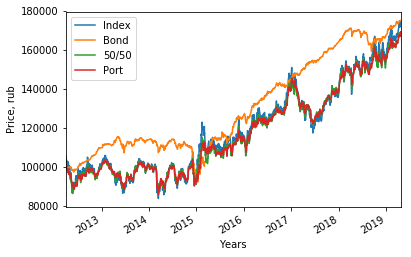

In [26]:
ax = temp.plot()
ax.set_ylabel("Price, rub")
ax.set_xlabel("Years")

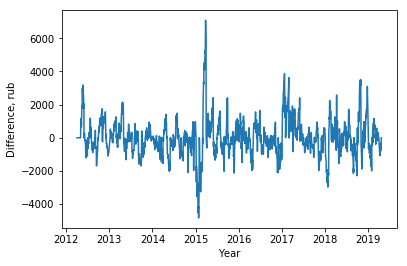

In [27]:
_=plt.plot(work_block.index, (work_block['Port'] - work_block['50/50']))
_=plt.xlabel('Year')
_=plt.ylabel('Difference, rub')

In [49]:
act = []
for i in range(1, 100):
    v = 100000
    port_weight = [i / 100, 1 - i / 100]
    p_v = [i * v for i in port_weight]
    # assets share
    bc_share = round(p_v[0] / main['Index'][0], 4)
    bn_share = round(p_v[1] / main['Bond'][0], 4)
    temp = pd.DataFrame({
                        'Blue Chips': main['Index'], 'Index Share': bc_share,
                        'Port': main['Index'] * bc_share + main['Bond'] * bn_share,
                        })
    temp['ss'] = temp['Blue Chips'] * temp['Index Share'] / temp['Port']
    act.append(max(temp['ss']) - min(temp['ss']))

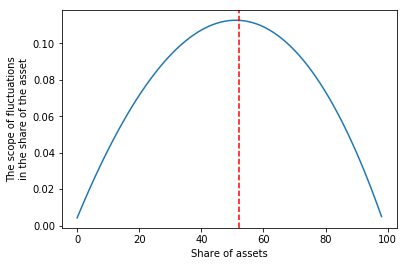

In [63]:
_=plt.plot(range(len(act)), act)
_=plt.xlabel('Share of assets')
_=plt.ylabel('The scope of fluctuations' + '\n' + 'in the share of the asset')
_=plt.axvline(x = act.index(max(act)) + 1, color = 'red', linestyle = '--')